### Análise Exploratória de Dados

In [90]:
# Importando as bibliotecas: Pandas e Matplotlib.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [91]:
# Carregando o dataset.
ibm = pd.read_csv("../dados/IBM.csv", names=["data", "abertura", "alta", "baixa", "fechamento", "fechamento_ajustado", "volume"], header=0)

In [92]:
# Obtendo algumas informações de metadados do dataset.
ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   data                 6118 non-null   object 
 1   abertura             6118 non-null   float64
 2   alta                 6118 non-null   float64
 3   baixa                6118 non-null   float64
 4   fechamento           6118 non-null   float64
 5   fechamento_ajustado  6118 non-null   float64
 6   volume               6118 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 334.7+ KB


In [93]:
# Fazendo a limpeza dos dados e convertendo eles para formatos de maior legibilidade.
ibm["data"] = pd.to_datetime(ibm["data"])
ibm["abertura"] = ibm["abertura"].round(3)
ibm["alta"] = ibm["alta"].round(3)
ibm["baixa"] = ibm["baixa"].round(3)
ibm["fechamento"] = ibm["fechamento"].round(3)
ibm["fechamento_ajustado"] = ibm["fechamento_ajustado"].round(3)

In [94]:
# Remoção de valores nulos
ibm = ibm.dropna()

In [95]:
# Gerando estatísticas de tendência de centralidade, dispersão e distribuição.
estatisticas = pd.DataFrame({
    "média": ibm.mean(numeric_only=True),
    "moda": ibm.mode(numeric_only=True).iloc[0],
    "mediana": ibm.median(numeric_only=True),
    "desvio-padrão": ibm.std(numeric_only=True),
    "variância": ibm.var(numeric_only=True),
    "assimetria": ibm.skew(numeric_only=True),
    "curtose": ibm.kurtosis(numeric_only=True)
})
estatisticas.round(3)

,média,moda,mediana,desvio-padrão,variância,assimetria,curtose
abertura,125.580,101.816,124.159,34.380,1.181961e+03,0.254,-0.811
alta,126.712,105.163,125.254,34.438,1.185999e+03,0.252,-0.802
baixa,124.528,94.168,123.078,34.318,1.177693e+03,0.258,-0.815
fechamento,125.637,85.086,124.198,34.385,1.182335e+03,0.254,-0.808
fechamento_ajustado,86.724,42.536,95.755,32.369,1.047778e+03,0.217,-0.636
volume,6181655.716,2590001.000,5313628.000,3449506.289,1.189909e+13,2.500,11.646


In [96]:
# Calculando a volatidade dos indicadores, utilizando o desvio-padrão sobre a mediana.
volatilidade = pd.DataFrame({
    "volatilidade": (estatisticas["desvio-padrão"] / estatisticas["mediana"]).round(3)
})
volatilidade

,volatilidade
abertura,0.277
alta,0.275
baixa,0.279
fechamento,0.277
fechamento_ajustado,0.338
volume,0.649


In [97]:
# Gerando uma matriz de correlação linear.
matriz_correlacao = ibm[["abertura", "alta", "baixa", "fechamento", "fechamento_ajustado", "volume"]].corr()
matriz_correlacao

,abertura,alta,baixa,fechamento,fechamento_ajustado,volume
abertura,1.000000,0.999539,0.999529,0.999090,0.874191,-0.388411
alta,0.999539,1.000000,0.999337,0.999554,0.874190,-0.379594
baixa,0.999529,0.999337,1.000000,0.999547,0.874279,-0.397937
fechamento,0.999090,0.999554,0.999547,1.000000,0.874515,-0.388774
fechamento_ajustado,0.874191,0.874190,0.874279,0.874515,1.000000,-0.413889
volume,-0.388411,-0.379594,-0.397937,-0.388774,-0.413889,1.000000


### Interpretações

Após a geração de um DataFrame de estatísticas e outro DataFrame de correlação linear entre as variáveis, podemos observar os seguintes pontos:

1. Os valores de média, mediana e moda para a abertura, alta, baixa e fechamento são muito similares. Em especial, a média é muito próxima da mediana, que implica em pouca variação dos dados. Além disso, a moda indica que os valores cotados das ações, tendem a ser mais baixos que a média.

2. O desvio padrão e a variância indicam que os preços tem uma certa volatidade, chegando até 27% do valor médio de uma ação. O volume de ações no mercado também sofre de um desvio padrão muito grande, indicando que há dias com um volume de movimentações muito intensos.

3. Na matriz de correlação linear, percebemos que a abertura, alta, baixa e fechamento possuem correlações positivas altíssimas, indicando que, quando uma se move, a outra também se move.

4. Por fim, na matriz de correlação linear, observamos um tendência fraca e inversa no volume. Ou seja, em dias que as ações estão baratas, o volume de movimentações é maior, e nos dias em que as ações são mais caras, o volume é menor.

### Visualizações

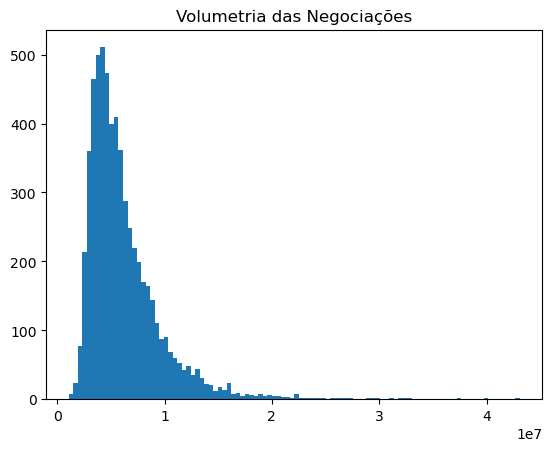

In [98]:
plt.hist(ibm["volume"], bins=100)
plt.title("Volumetria das Negociações")
plt.show()

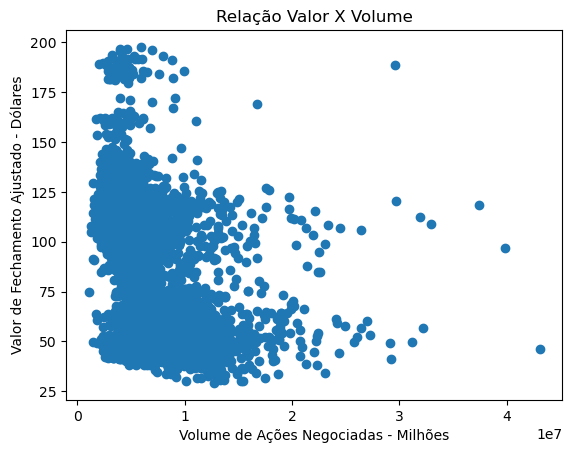

In [99]:
plt.scatter(ibm["volume"], ibm["fechamento_ajustado"])
plt.ylabel("Valor de Fechamento Ajustado - Dólares")
plt.xlabel("Volume de Ações Negociadas - Milhões")
plt.title("Relação Valor X Volume")
plt.show()

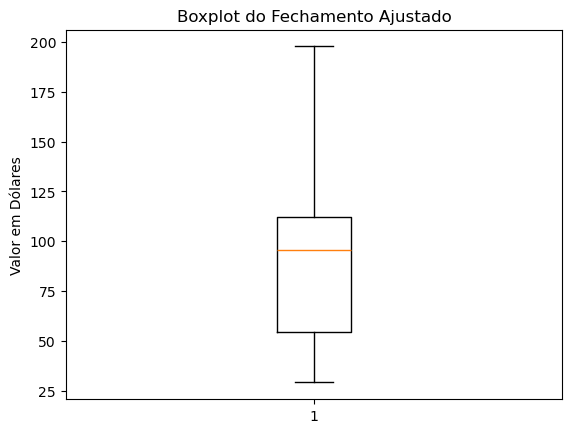

In [100]:
plt.boxplot(ibm["fechamento_ajustado"])
plt.title("Boxplot do Fechamento Ajustado")
plt.ylabel("Valor em Dólares")
plt.show()

### Regressão Linear

Vamos conduzir um estudo para tentar responder a seguinte pergunta: O de fechamento ajustado impacta o volume de ações negociadas?

In [101]:
# Variável independente.
x = ibm[["fechamento_ajustado"]]
# Variável dependente.
y = ibm["volume"]

In [102]:
# Divisão da base de treinos e da base de testes.
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, random_state=42)

In [103]:
# Treinando o modelo.
modelo = LinearRegression()
modelo.fit(x_treino, y_treino)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [104]:
# Valores do resultado do modelo de regressão linear.
previsao = modelo.predict(x_teste)
previsao

array([5225210.1733005 , 5359443.07326522, 5704112.86860693, ...,
       4483053.33062444, 4615753.39160098, 7628789.29756273],
      shape=(1836,))

In [105]:
y_pred = modelo.predict(x_treino)
y_pred

array([6037921.40483241, 6721480.00276042, 5351034.35653007, ...,
       5490697.88605291, 4568804.72316308, 8095998.62115935],
      shape=(4282,))

In [106]:
# Medindo a acurácia do modelo.

# Coeficiente angular e intercepto.
print("Coeficiente:", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)

# Aplicando a previsão.
y_previsao = modelo.predict(x_teste)

# Avaliando o desempenho.
mse = mean_squared_error(y_test, y_previsao)
r2 = r2_score(y_test, y_previsao)
print("MSE:", mse)
print("R²:", r2)

Coeficiente: -43795.39966222492
Intercepto: 10007273.657818504
MSE: 10600519536856.543
R²: 0.16515587369856466


### Interpretação

O modelo de regresão linear não é muito apto para fazer este tipo de análise. Não encontramos uma boa medição para o coeficiente, apenas uma relação inversa, indicando que valores altos de fechamento ajustado, implicam em um volume menor de negociações. Além disso, o Erro Médio Quadrático é extremamente elevado, tendo baixa usabilidade. E o R² do fechamento ajustado explica apenas 16% da variação do volume.